# Logging Results

In [3]:
def log_top_matches(query, model_name, top_indices, similarities, full_psalms, filename="query_results.txt"):
    """
    Write the top psalm matches to a results file (and print them).
    Includes the original query and model information as a heading.
    """
    output_lines = []
    output_lines.append("=" * 80)
    output_lines.append(f"Query: {query}")
    output_lines.append(f"Model: {model_name}")
    output_lines.append("Top 5 matching psalms:")

    line_length = 125

    for rank, idx in enumerate(top_indices, start=1):
        text_type = "Bible" if idx <= 151 else "Psalter"
        num = idx if idx <= 151 else idx - 151
        psalm = full_psalms.iloc[idx]['verse']
        formatted_verse = ""
        # split into lines of length `line_length`
        for i in range(0, len(text), line_length):
            formatted_verse += psalm[i:i+line_length] + "\n"

        line = (
            f"{rank}. {text_type} Psalm {num + 1} - Similarity: {similarities[idx]}%\n"
            f"{formatted_verse}\n"
        )
        output_lines.append(line)

    # Combine into one result block
    result_block = "\n".join(output_lines)

    # Print to console
    print(result_block)

    # Append to a file
    with open(filename, "a", encoding="utf-8") as f:
        f.write(result_block + "\n\n")

# TF-IDF

# GLoVe X TFIDF

In [4]:
import pandas as pd
import numpy as np

psalms = pd.read_csv("data/psalms_with_vectors.txt")

In [5]:
psalms


Unnamed: 0 tradition     text  psalm_num  \
0             0  Orthodox    Bible          1   
1             1  Orthodox    Bible          2   
2             2  Orthodox    Bible          3   
3             3  Orthodox    Bible          4   
4             4  Orthodox    Bible          5   
..          ...       ...      ...        ...   
296         296  Orthodox  Psalter        146   
297         297  Orthodox  Psalter        147   
298         298  Orthodox  Psalter        148   
299         299  Orthodox  Psalter        149   
300         300  Orthodox  Psalter        150   

                                                 verse  \
0    Blessed is the man Who walks not in the counse...   
1    Why do the nations rage And the people meditat...   
2    A psalm by David when he fled from the face of...   
3    For the End in psalms an ode by David You hear...   
4    For the End concerning the inheritance a psalm...   
..                                                 ...   
296  The Lord doth build up Jerusalem; He shall gat...   
297  Praise the Lord, O Jerusalem; praise thy God, ...   
298  Praise ye the Lord from the heavens; praise Hi...   
299  Sing unto the Lord a new song, His praise is i...   
300  Praise God in His holy ones; praise Him in the...   

                                         cleaned_verse  \
0    blessed man walk counsel ungodly stand way sin...   
1    nation rage people meditate vain thing king ea...   
2    psalm david fled face son absalom olord afflic...   
3    end psalm ode david heard icalled god righteou...   
4    end concerning inheritance psalm david give ea...   
..                                                 ...   
296  lord doth build jerusalem ; shall gather toget...   
297  praise lord , jerusalem ; praise thy god , zio...   
298  praise ye lord heaven ; praise highest . prais...   
299  sing unto lord new song , praise congregation ...   
300  praise god holy one ; praise firmament power ....   

                                       glove_tfidf_vec  \
0    [ 0.04116335 -0.16281123  0.01578085  0.102900...   
1    [-0.09802769 -0.09030678  0.08969123  0.121389...   
2    [-0.02370331 -0.02989303 -0.06902936  0.134278...   
3    [-0.04905575 -0.02581999 -0.03994774  0.128105...   
4    [ 0.00102828 -0.09200042 -0.07703259  0.243362...   
..                                                 ...   
296  [-8.69649883e-02  2.96077896e-02  2.16656047e-...   
297  [-0.07291189 -0.04181115  0.07198007  0.143565...   
298  [-0.07403488 -0.20329297  0.0287572   0.182462...   
299  [-0.01585722 -0.07310608 -0.04004482  0.236639...   
300  [ 3.44652246e-03 -2.73287113e-01 -2.01784975e-...   

                                                 glove  
0    [-0.01810831 -0.2523851   0.00547219  0.195684...  
1    [-0.13752478 -0.16025928  0.08164851  0.207276...  
2    [-0.06051026 -0.02464193 -0.06952135  0.176681...  
3    [-0.08449795 -0.0195749   0.00881046  0.162734...  
4    [-0.0342767  -0.13337569 -0.09014621  0.313558...  
..                                                 ...  
296  [-0.00202334 -0.09045612  0.07749773  0.364389...  
297  [-0.00506784 -0.17236896  0.10899492  0.362852...  
298  [ 0.06032175 -0.2944392   0.16987029  0.447312...  
299  [ 0.0506989  -0.22018342 -0.01928143  0.459914...  
300  [ 0.06967841 -0.13542674  0.11822294  0.323153...  

[301 rows x 8 columns]

In [6]:
glove_vectors = {}

with open("word_embeddings/vectors.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split()        # split by spaces
        word = parts[0]                     # first part is the word
        vector = [float(x) for x in parts[1:]]  # rest are floats
        glove_vectors[word] = vector


# glove_vectors

In [7]:
embedding_dim = len(next(iter(glove_vectors.values())))  # get embedding dimension

In [8]:
import pickle 
import os
print(os.getcwd())

# getting the pickle file ready to be used
with open("../../data/models/psalms_tfidf_matrix.pickle", "rb") as file:
    tfidf_matrix = pickle.load(file)

/Users/caden/st_david-s-beacon/website/scripts/fall 2025


In [9]:
# Number of documents
N = tfidf_matrix.shape[0]

# Count how many docs contain each word
df = np.sum(tfidf_matrix > 0, axis=0)  # document frequency

# Compute IDF
idf_weights = np.log((N + 1) / (df + 1)) + 1  # standard smoothed IDF

# Map to dict
idf_weights = dict(zip(tfidf_matrix.columns, idf_weights))

In [10]:
def compute_query_embedding(query):
    tokens = query.lower().split()  # lowercase, remove punctuation, tokenize
    
    numerator = np.zeros(embedding_dim)
    denominator = 0

    for word in tokens:
        if word in glove_vectors and word in idf_weights:
            weight = idf_weights[word]  # or full TF-IDF if TF available
            numerator += glove_vectors[word] * weight
            denominator += weight

    if denominator == 0:
        return None

    return numerator / denominator


In [11]:
import numpy as np

def ensure_array(x):
    if isinstance(x, str):
        # string like "[0.04116335 -0.16281123 ...]"
        x = x.strip("[]")  # remove brackets
        numbers = [float(n) for n in x.split()]
        return np.array(numbers, dtype=float)
    elif isinstance(x, list):
        # list -> array
        return np.array(x, dtype=float)
    elif isinstance(x, np.ndarray):
        # already array, do nothing
        return x
    else:
        # fallback to zero vector if something else
        return np.zeros(300)  # replace 300 with your embedding_dim

psalms["glove_tfidf_vec"] = psalms["glove_tfidf_vec"].apply(ensure_array)

# Check
print(type(psalms["glove_tfidf_vec"].iloc[0]))  # <class 'numpy.ndarray'>
print(psalms["glove_tfidf_vec"].iloc[0].shape)


<class 'numpy.ndarray'>
(100,)


In [12]:

# Check
print(type(psalms["glove_tfidf_vec"].iloc[0]))  # should be <class 'numpy.ndarray'>
print(psalms["glove_tfidf_vec"].iloc[0].shape)  # should show (embedding_dim,)



<class 'numpy.ndarray'>
(100,)


In [13]:
print(type(psalms["glove_tfidf_vec"].iloc[0]))  # <class 'numpy.ndarray'>
print(psalms["glove_tfidf_vec"].iloc[0].shape)  # e.g., (300,)


<class 'numpy.ndarray'>
(100,)


In [14]:
import numpy as np

for word in glove_vectors:
    glove_vectors[word] = np.array(glove_vectors[word], dtype=float)


In [108]:
def query_tfidf_glove(query, top_k=6):
    # Compute query embedding
    q_vec = compute_query_embedding(query)
    if q_vec is None:
        return []  # return empty list if no valid words in query

    # Precompute query norm once
    q_norm = np.linalg.norm(q_vec)
    if q_norm == 0:
        return []

    sims = []

    # Iterate over each row in the DataFrame
    for idx, row in psalms.iterrows():
        doc_vec = row['glove_tfidf_vec']
        doc_norm = np.linalg.norm(doc_vec)
        if doc_norm == 0:
            continue  # skip empty embeddings

        # Cosine similarity
        sim = np.dot(q_vec, doc_vec) / (q_norm * doc_norm)
        sims.append((idx, round(sim*100, 2)))  # store index and similarity

    # Sort by similarity in descending order
    sims.sort(key=lambda x: x[1], reverse=True)

    # Return the top_k indices
    top_indices = [("TFIDF_GLoVe", idx,sim) for idx, sim in sims[:top_k]]
    
    return (top_indices)


## Testing 


In [94]:
query = "For the Peace of the World"

(query_tfidf_glove(query))

[('TFIDF_GLoVe', 91, 0.4372846747039288),
 ('TFIDF_GLoVe', 271, 0.4099898925400447),
 ('TFIDF_GLoVe', 120, 0.40992674506662063),
 ('TFIDF_GLoVe', 130, 0.3873788312591205),
 ('TFIDF_GLoVe', 95, 0.3843412811685719),
 ('TFIDF_GLoVe', 236, 0.38267986033828955)]

# BERT & SBERT

## BERT

In [17]:
print(os.getcwd())
output_dir = "data/bert"
psalm_embeddings = []

# Load all saved embeddings
for filename in sorted(os.listdir(output_dir)):
    if filename.endswith(".npy") and "psalm_" in filename:
        emb = np.load(os.path.join(output_dir, filename))
        psalm_embeddings.append(emb)

psalm_embeddings = np.stack(psalm_embeddings)  # shape: (num_psalms, 768)
print("Loaded psalm embeddings:", psalm_embeddings.shape)


/Users/caden/st_david-s-beacon/website/scripts/fall 2025


Loaded psalm embeddings: (301, 768)


In [18]:
# --- Clean Psalm Encoder using BERT ---
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# 1️⃣ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2️⃣ Load tokenizer and model (fresh instances)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()  # evaluation mode

Using device: cpu


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
def encode_text_bert(text: str) -> np.ndarray:
    """
    Encode a single text string into a 1D numpy array (hidden_size,)
    Uses attention-mask weighted mean to ignore padding.
    """
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    
    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = bert_model(**inputs)  # last_hidden_state: (1, seq_len, hidden)
        hidden = outputs.last_hidden_state
        mask = inputs.get("attention_mask")
        
        if mask is None:
            pooled = hidden.mean(dim=1)
        else:
            mask = mask.unsqueeze(-1)  # (1, seq_len, 1)
            masked_hidden = hidden * mask
            summed = masked_hidden.sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1e-9)
            pooled = summed / counts
    
    return pooled.squeeze(0).cpu().numpy()

In [20]:
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """Compute cosine similarity between two 1D numpy arrays."""
    a_norm = a / np.linalg.norm(a)
    b_norm = b / np.linalg.norm(b)
    return float(np.dot(a_norm, b_norm))

In [90]:
def query_bert(query, top_k=5):

    print("BERT Query: ", query)

    if not query:
        print("Empty query. Exiting.")
        return
    
    # 1. Encode query with BERT
    query_emb = encode_text_bert(query)

    # 2. Compute similarities
    similarities = []
    for i, psalm_emb in enumerate(psalm_embeddings):
        sim = cosine_similarity(query_emb, psalm_emb)
        similarities.append((i, round(sim * 100, 2)))  # store index + sim %

    # 3. Sort by similarity descending
    sims = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]



    # Return the top_k indices
    top_results = [("BERT", idx,sim) for idx, sim in sims[:top_k]]


    return (top_results)

    # 4. Log matches (and write to file)
    ''' log_top_matches(query,
        model_name="BERT",
        top_indices=top_indices,
        similarities=similarities,
        full_psalms=full_psalms,
    )'''

## Testing

In [91]:
(query_bert(query))

BERT Query:  For the Peace of the World


[('BERT', 184, 99.19),
 ('BERT', 17, 99.11),
 ('BERT', 199, 99.11),
 ('BERT', 129, 99.09),
 ('BERT', 193, 99.09)]

## SBERT

In [23]:
from sentence_transformers import SentenceTransformer

# Use a pretrained SBERT model
sbert_model = SentenceTransformer('all-mpnet-base-v2')  # or any SBERT variant

In [24]:
utput_dir = "data/sbert"
psalm_SBERT_embeddings = []

# Load all saved embeddings
for filename in sorted(os.listdir(output_dir)):
    if filename.endswith(".npy") and "psalm_" in filename:
        emb = np.load(os.path.join(output_dir, filename))
        psalm_SBERT_embeddings.append(emb)

psalm_SBERT_embeddings = np.stack(psalm_SBERT_embeddings)  # shape: (num_psalms, 768)
print("Loaded psalm embeddings:", psalm_SBERT_embeddings.shape)

Loaded psalm embeddings: (301, 768)


In [25]:
def encode_text_SBERT(text):
    return sbert_model.encode(text, convert_to_numpy=True)

In [80]:
def query_sbert(query, top_k=5):
    print("Query: ", query)

    if not query:
        print("Empty query. Exiting.")
        return
    
    query_emb = encode_text_SBERT(query)

    similarities = []

    for i, psalm_emb in enumerate(psalm_SBERT_embeddings):
        sim = cosine_similarity(query_emb, psalm_emb)
        similarities.append((i, round(sim*100, 2)))

    
    # 3. Sort by similarity descending
    sims = sorted(similarities, reverse=True)[:5]
    

    # Return the top_k indices
    top_results = [("SBERT", idx,sim) for idx, sim in sims[:top_k]]

    # Checking the Output
    return (top_results)

## Testing

In [81]:
print(query_sbert(query))

Query:  For the Peace of the World
[('SBERT', 300, 96.09), ('SBERT', 299, 96.1), ('SBERT', 298, 96.13), ('SBERT', 297, 96.11), ('SBERT', 296, 96.12)]


#### Comparing Embedding sizes

I am getting very low similarity percentages for `SBERT` results compared to `BERT` results. There are a few things that may be contributing to this. One of them may have to do with the different dimensions of embeddings between `BERT` & `SBERT`. Let look at that first. 

In [58]:
print(f"BERT Embeddings: {psalm_embeddings.shape}")
print(f"SBERT Embeddings: {psalm_SBERT_embeddings.shape}")

BERT Embeddings: (301, 768)
SBERT Embeddings: (301, 768)


The dimensions for both are the same, therefore the problems seems like i t lies within the `SBERT` algorithm itself. Lets look at the embeddings for `SBERT` closer and see what is happening. We are going to look at the embeddings right before the cosine similarity is calculated and see if there are any negatives within the embeddings. 

In [60]:
def query_sbert(query, top_k=5):
    print("Query: ", query)

    if not query:
        print("Empty query. Exiting.")
        return
    
    query_emb = encode_text_SBERT(query)

    similarities = []

    for i, psalm_emb in enumerate(psalm_SBERT_embeddings):
        print(f"Query: {query_emb} \n Emedding: {psalm_emb}")
        sim = cosine_similarity(query_emb, psalm_emb)
        similarities.append((i, round(sim*100, 2)))

    
    # 3. Sort by similarity descending
    sims = sorted(similarities, reverse=True)[:5]
    

    # Return the top_k indices
    top_indices = [("SBERT", idx,sim) for idx, sim in sims[:top_k]]

    # Checking the Output
    print(top_indices)

In [61]:
query_sbert(query)

Query:  For the Peace of the World
Query: [ 6.06075302e-02  5.24650551e-02  2.15235515e-03 -2.08576745e-03
 -3.75669263e-02 -4.92065074e-03  3.90308909e-02 -1.25705488e-02
  2.66557112e-02  6.71257526e-02  4.86358888e-02 -4.65650633e-02
  9.07771103e-03 -5.90843409e-02  2.09817868e-02 -4.27574515e-02
  2.72971727e-02 -3.44783179e-02  2.63962895e-02  1.64397471e-02
 -2.79004630e-02  4.64916527e-02 -1.68762524e-02  5.50022069e-03
 -2.84583066e-02 -1.54242935e-02 -1.16044618e-02  9.61969886e-03
 -5.49704814e-03  1.17908660e-02 -4.69791144e-02 -6.64177015e-02
  3.79722342e-02 -7.54136816e-02  1.57801821e-06 -2.32564122e-03
  2.42029540e-02  3.08251884e-02 -8.09351802e-02 -5.36750704e-02
 -4.29216921e-02 -2.98326761e-02 -3.76765765e-02 -3.12715508e-02
  7.65241496e-03  4.04009074e-02  1.42012881e-02 -3.81755531e-02
 -3.09198946e-02  4.42713685e-02  2.46081352e-02  2.02556849e-02
 -5.68439476e-02 -2.37042513e-02 -4.91136163e-02 -1.28113674e-02
  4.93451545e-04 -5.25199287e-02  7.54563278e-03

KeyboardInterrupt: 

It can be seen that there are negative values within the embeddings and because of this it is interfereing with the score and making them seem lower than they actually are. We can write a simple sunction to basically shift all of the embedding to be strictly **positive**, which should fix the off balance of similarity scores. 

In [67]:
def shift_embedding(embedding):
    min_val = embedding.min()
    shifted = embedding - min_val

    return shifted

We can now apply this to the embeddings themselves and then look at the similarities again and see if this affected the similarities. 

In [70]:
psalm_SBERT_embeddings = shift_embedding(psalm_SBERT_embeddings)

In [71]:
def query_sbert(query, top_k=5):
    print("Query: ", query)

    if not query:
        print("Empty query. Exiting.")
        return
    
    query_emb = encode_text_SBERT(query)

    similarities = []

    # Shifting the Embeddings
    query_emb = shift_embedding(query_emb)
    #psalm_SBERT_embeddings = shift_embedding(psalm_SBERT_embeddings)

    for i, psalm_emb in enumerate(psalm_SBERT_embeddings):
        print(f"Query: {query_emb} \n Emedding: {psalm_emb}")
        sim = cosine_similarity(query_emb, psalm_emb)
        similarities.append((i, round(sim*100, 2)))

    
    # 3. Sort by similarity descending
    sims = sorted(similarities, reverse=True)[:5]
    

    # Return the top_k indices
    top_indices = [("SBERT", idx,sim) for idx, sim in sims[:top_k]]

    # Checking the Output
    print(top_indices)

Let's run the same query again and see if there are different results given. 

In [72]:
query_sbert(query)

Query:  For the Peace of the World
Query: [0.18852833 0.18038584 0.13007315 0.12583503 0.09035386 0.12300014
 0.16695169 0.11535025 0.15457651 0.19504654 0.17655668 0.08135573
 0.1369985  0.06883645 0.14890258 0.08516334 0.15521796 0.09344247
 0.15431708 0.14436054 0.10002033 0.17441244 0.11104454 0.13342102
 0.09946249 0.1124965  0.11631633 0.13754049 0.12242375 0.13971166
 0.08094168 0.06150309 0.16589302 0.05250711 0.12792237 0.12559515
 0.15212375 0.15874597 0.04698561 0.07424572 0.0849991  0.09808812
 0.09024422 0.09664924 0.13557321 0.1683217  0.14212207 0.08974524
 0.0970009  0.17219216 0.15252893 0.14817648 0.07107684 0.10421654
 0.07880718 0.11510942 0.12841424 0.07540086 0.13546643 0.18369356
 0.18811582 0.16924874 0.12029766 0.07962362 0.11895302 0.12250456
 0.1553355  0.16033417 0.17097446 0.10075627 0.11025389 0.10740432
 0.15649426 0.22672561 0.15471387 0.09112942 0.10015309 0.1436906
 0.15500559 0.16815536 0.21378207 0.14241394 0.13443625 0.12443307
 0.14318545 0.1727439

KeyboardInterrupt: 

All of our embeddings are no2w strictly positive. lets run the query now. 

In [86]:
def query_sbert(query, top_k=5):
    print("Query: ", query)

    if not query:
        print("Empty query. Exiting.")
        return
    
    query_emb = encode_text_SBERT(query)

    similarities = []

    # Shifting the Embeddings
    query_emb = shift_embedding(query_emb)
    #psalm_SBERT_embeddings = shift_embedding(psalm_SBERT_embeddings)

    for i, psalm_emb in enumerate(psalm_SBERT_embeddings):
        #print(f"Query: {query_emb} \n Emedding: {psalm_emb}")
        sim = cosine_similarity(query_emb, psalm_emb)
        similarities.append((i, round(sim*100, 2)))

    
    # 3. Sort by similarity descending
    sims = sorted(similarities, reverse=True)[:5]
    

    # Return the top_k indices
    top_indices = [("SBERT", idx,sim) for idx, sim in sims[:top_k]]

    # Checking the Output
    return (top_indices)

query_sbert(query)

Query:  For the Peace of the World


[('SBERT', 300, 96.09),
 ('SBERT', 299, 96.1),
 ('SBERT', 298, 96.13),
 ('SBERT', 297, 96.11),
 ('SBERT', 296, 96.12)]

With the embeddings a shfited, we are now getting really high similarities which could be a good thing. Lets now update the `cosine_similarity()` function to handle the shifting as all three algorithms are using this to compare and gather results. We are going to take the shifting out of the SBERT algorithm first. 

In [159]:
def query_sbert(query, top_k=5):
    query_emb = encode_text_SBERT(query)

    similarities = []
    for i, psalm_emb in enumerate(psalm_SBERT_embeddings):
        sim = cosine_similarity(query_emb, psalm_emb)
        similarities.append((i, sim))  # store raw similarity (not scaled)

    # Sort by similarity descending
    sims = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # Return (method, index, similarity%) for top_k results
    top_indices = [("SBERT", idx, round(sim * 100, 2)) for idx, sim in sims]

    return top_indices


In [160]:
query_sbert("Have mercy on me, O God, have mercy on me. For my soul trusts in Thee, and in the shadow of Thy wings will I hope, until iniquity pass away.")

[('SBERT', 10, 96.41),
 ('SBERT', 229, 96.41),
 ('SBERT', 296, 96.41),
 ('SBERT', 12, 96.41),
 ('SBERT', 247, 96.4)]

Then update the `cosine_similarity()` function. 

In [75]:
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    ''' Ensuring that both embeddings are strictly positive'''
    if a.min() < 0:
        a = shift_embedding(a)
    
    if b.min() < 0:
        b = shift_embedding(b)
        
    """Compute cosine similarity between two 1D numpy arrays."""
    a_norm = a / np.linalg.norm(a)
    b_norm = b / np.linalg.norm(b)
    return float(np.dot(a_norm, b_norm))

Now lets examine of the results of all of the algorithms together. 

# Testing All Algorithms

In [99]:
def query_all(q):
    # GLoVe scaled by TF_IDF 
    (query_tfidf_glove(q))
    # BERT
    query_bert(q)
    # SBERT
    query_sbert(q)

print(query_all("For the Peace of the world"))



[('TFIDF_GLoVe', 91, 0.4372846747039288), ('TFIDF_GLoVe', 271, 0.4099898925400447), ('TFIDF_GLoVe', 120, 0.40992674506662063), ('TFIDF_GLoVe', 130, 0.3873788312591205), ('TFIDF_GLoVe', 95, 0.3843412811685719), ('TFIDF_GLoVe', 236, 0.38267986033828955)]
BERT Query:  For the Peace of the world
Query:  For the Peace of the world
None


I want to be able to store ans keep track of the data generate by each of the three algorithms based on the queries. I want to store it all in a dataFrame for future analaysis

## Storing Algorithm


In [161]:
full_results = pd.DataFrame(columns= ["Query", "Method", "Similarity Score (%)", "Text", "Psalm Num", "Verse"] )

In [162]:
def record_results(query, results):
    for result in results:
        method, index, sim = result
        target_psalm = psalms.iloc[index]
        text = target_psalm["text"]
        psalm_num = target_psalm["psalm_num"]
        verse = target_psalm["verse"]

        # Correct way to append a row
        full_results.loc[len(full_results)] = [query, method, sim, text, psalm_num, verse]



In [163]:
def query_all(q):
    # GLoVe scaled by TF_IDF 
    record_results(q, query_tfidf_glove(q))
    # BERT
    record_results(q, query_bert(q))
    # SBERT
    record_results(q, query_sbert(q))

query_all("For the Peace of the world")

BERT Query:  For the Peace of the world


In [164]:
full_results

Query       Method  Similarity Score (%)     Text  Psalm Num                                                                                                                                                                                Verse
0   For the Peace of the world  TFIDF_GLoVe                 43.73    Bible         92  1For the day before the Sabbath when the earth was settled the praise of an ode by  David The Lord reigns He clothed Himself with majesty The Lord clothed and girded Himself wi...
1   For the Peace of the world  TFIDF_GLoVe                 41.00  Psalter        121  I was glad because of them that said to me, Let us go into the house of the Lord. Our feet have stood within thy courts, O Jerusalem. Jerusalem is builded as a city that is com...
2   For the Peace of the world  TFIDF_GLoVe                 40.99    Bible        121  1An ode of ascents Iwas glad when they said to me Let us go into the house of the Lord Our feet stand in your courts O Jerusalem Jerusalem is built as a city Whose compactness ...
3   For the Peace of the world  TFIDF_GLoVe                 38.74    Bible        131  1An ode of ascents Remember David O Lord And all his meekness How he swore to the Lord How he vowed to the God of Jacob 3Ishall not enter my dwelling I shall not recline on my ...
4   For the Peace of the world  TFIDF_GLoVe                 38.43    Bible         96  By David when His earth is restored The Lord reigns let the earth greatly rejoice Let the many islands be glad Clouds and darkness surround Him Righteousness and judgment are t...
5   For the Peace of the world  TFIDF_GLoVe                 38.27  Psalter         86  His foundations are in the holy mountains. The Lord loveth the gates of Zion more than all the dwellings of Jacob. Glorious things are spoken of thee, O city of God. I will mak...
6   For the Peace of the world         BERT                 99.19  Psalter         34  Judge Thou, O Lord, them that do me injustice; fight against them that fight against me. Take hold of weapon and buckler, and rise up for mine help. Draw out the sword, and sto...
7   For the Peace of the world         BERT                 99.11    Bible         18  For the End a psalm by David The heavens declare the glory of God The firmament shows the creation of His hands Day to day utters speech And night to night reveals knowledge Th...
8   For the Peace of the world         BERT                 99.11  Psalter         49  The God of gods, even the Lord, hath spoken, and called the earth from the rising of the sun unto the going down thereof. Out of Zion is the comeliness of His beauty. God, our ...
9   For the Peace of the world         BERT                 99.09    Bible        130  1An ode of ascents by David OLord My heart is not exalted Neither are my eyes raised up Neither am I carried along in great things Nor in things too marvelous for me If I were ...
10  For the Peace of the world         BERT                 99.09  Psalter         43  We have heard with our ears, O God, for our fathers have told us, what work Thou didst in their days, in the days of old. Thine hand didst destroy the heathen, and Thou planted...
11  For the Peace of the world        SBERT                 96.17    Bible         22  A psalm by David The Lord is my shepherd I shall not want He makes me to lie down in green pastures He leads me beside the still waters He restores my soul He leads me in the p...
12  For the Peace of the world        SBERT                 96.17  Psalter        105  O give thanks unto the Lord, for He is good; for His mercy endureth for ever. Who shall utter the mighty acts of the Lord? Who shall make all His praises to be heard? Blessed a...
13  For the Peace of the world        SBERT                 96.16  Psalter         98  The Lord reigneth; let the people rage: He sitteth upon the cherubim, let the earth be moved. The Lord is great in Zion, and He is high above all the peoples. Let them praise T...
14  For the Peace of

# Graphing Results

In [165]:
import matplotlib.pyplot as plt


In [166]:
plt.scatter(full_results['Psalm Num'], full_results["Similarity Score (%)"])

plt.show()



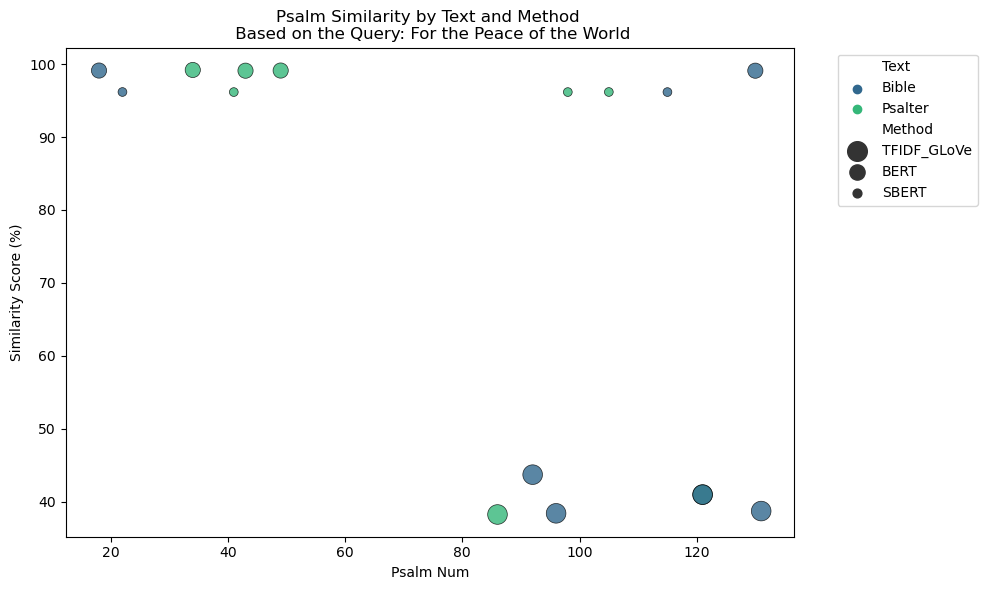

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=full_results,
    x="Psalm Num",
    y="Similarity Score (%)",
    hue="Text",       # color by text
    size="Method",    # scale by method
    palette="viridis",
    sizes=(40, 200),
    alpha=0.8,
    edgecolor="k"
)

plt.title(f"Psalm Similarity by Text and Method \n Based on the Query: {query}")
#plt.suptitle(f"Based on the Query: {query}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [168]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

In [169]:
# Defining a function for the graping
def graph_results(results):
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=results,
        x="Psalm Num",
        y="Similarity Score (%)",
        hue="Text",       # color by text
        size="Method",    # scale by method
        palette="viridis",
        sizes=(40, 200),
        alpha=0.8,
        edgecolor="k"
    )

    line

    query = textwrap.fill(results.iloc[0]["Query"], width=60)

    plt.title(f"Psalm Similarity by Text and Method \n Based on the Query: {query}")
    #plt.suptitle(f"Based on the Query: {query}")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


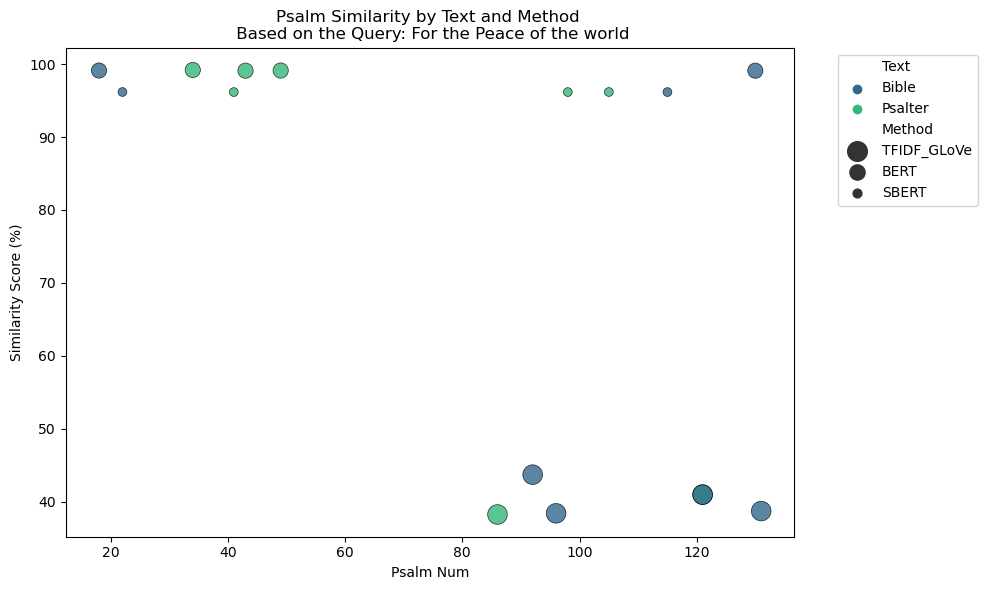

In [170]:
graph_results(full_results)

With everything needed to implents some investigations, lets work on runing a bunch of different queries to be able to look for any trends that may emerge. After a little thought and consulting ChatGPT I am going to use the following queries to test on all three of the algorithms. 
### Psalms Search Test Queries

#### 1. Simple Keyword Queries
- **Query 1:** mercy

#### 2. Phrase/Exact Match Queries
- **Query 2:** The Lord is my shepherd

#### 3. Thematic/Semantic Queries
- **Query 3:** protection from enemies
- **Query 4:** praise in times of suffering

#### 4. Long/Complex Queries
- **Query 5:** How does the psalmist express trust in God while surrounded by fear and uncertainty?
- **Query 6:** Verses where the psalmist remembers past deliverance and uses it to find hope in present trials.

#### 5. Orthodox Service Quotes
##### From *Vespers*
- **Query 7:** 
    >"Rejoice, O ye heavens, sound the trumpets, ye foundation of the earth, thunder forth gladness, O ye mountains: for behold, Emanuel to    the Cross our sins, and the Giver of Life hath slain death, rasing up Adam,; for He loveth man kind."

- **Query 8:**
    >"“Have mercy on me, O God, have mercy on me. For my soul trusts in Thee, and in the shadow of Thy wings will I hope, until iniquity pass away.”

We can now store all of these within a dictionary to organize them.



In [171]:
# psalm_queries.py (you can save this to import later)
queries = [
    # 1. Simple Keyword Queries
    {"id": 1, "category": "Simple Keyword", "text": "mercy"},

    # 2. Phrase/Exact Match Queries
    {"id": 2, "category": "Phrase/Exact Match", "text": "The Lord is my shepherd"},

    # 3. Thematic/Semantic Queries
    {"id": 3, "category": "Thematic/Semantic", "text": "protection from enemies"},
    {"id": 4, "category": "Thematic/Semantic", "text": "praise in times of suffering"},

    # 4. Long/Complex Queries
    {"id": 5, "category": "Long/Complex", 
     "text": "How does the psalmist express trust in God while surrounded by fear and uncertainty?"},
    {"id": 6, "category": "Long/Complex", 
     "text": "Verses where the psalmist remembers past deliverance and uses it to find hope in present trials."},

    # 5. Orthodox Service Quotes
    {"id": 7, "category": "Orthodox Service (Vespers)", 
     "text": "Rejoice, O ye heavens, sound the trumpets, ye foundation of the earth, thunder forth gladness, O ye mountains: for behold, Emmanuel to the Cross our sins, and the Giver of Life hath slain death, raising up Adam; for He loveth mankind."},

    {"id": 8, "category": "Orthodox Service: Great Canon of St. Andrew of Crete ", 
     "text": "Have mercy on me, O God, have mercy on me. For my soul trusts in Thee, and in the shadow of Thy wings will I hope, until iniquity pass away."}
]


queries

[{'id': 1, 'category': 'Simple Keyword', 'text': 'mercy'},
 {'id': 2,
  'category': 'Phrase/Exact Match',
  'text': 'The Lord is my shepherd'},
 {'id': 3, 'category': 'Thematic/Semantic', 'text': 'protection from enemies'},
 {'id': 4,
  'category': 'Thematic/Semantic',
  'text': 'praise in times of suffering'},
 {'id': 5,
  'category': 'Long/Complex',
  'text': 'How does the psalmist express trust in God while surrounded by fear and uncertainty?'},
 {'id': 6,
  'category': 'Long/Complex',
  'text': 'Verses where the psalmist remembers past deliverance and uses it to find hope in present trials.'},
 {'id': 7,
  'category': 'Orthodox Service (Vespers)',
  'text': 'Rejoice, O ye heavens, sound the trumpets, ye foundation of the earth, thunder forth gladness, O ye mountains: for behold, Emmanuel to the Cross our sins, and the Giver of Life hath slain death, raising up Adam; for He loveth mankind.'},
 {'id': 8,
  'category': 'Orthodox Service: Great Canon of St. Andrew of Crete ',
  'text':

In [172]:
for q in queries:
    query_all(q['text'])

BERT Query:  mercy
BERT Query:  The Lord is my shepherd
BERT Query:  protection from enemies
BERT Query:  praise in times of suffering
BERT Query:  How does the psalmist express trust in God while surrounded by fear and uncertainty?
BERT Query:  Verses where the psalmist remembers past deliverance and uses it to find hope in present trials.
BERT Query:  Rejoice, O ye heavens, sound the trumpets, ye foundation of the earth, thunder forth gladness, O ye mountains: for behold, Emmanuel to the Cross our sins, and the Giver of Life hath slain death, raising up Adam; for He loveth mankind.
BERT Query:  Have mercy on me, O God, have mercy on me. For my soul trusts in Thee, and in the shadow of Thy wings will I hope, until iniquity pass away.


In [173]:
import pandas as pd

# Configure Pandas display options
pd.set_option('display.max_rows', 50)       # show all rows
pd.set_option('display.max_columns', None)    # show all columns
pd.set_option('display.max_colwidth', 180)   # don't truncate text
pd.set_option('display.expand_frame_repr', False)  # keep wide frames on one line

# Then simply display the DataFrame
full_results


Query       Method  Similarity Score (%)     Text  Psalm Num                                                                                                                                                                                Verse
0                                                                                                                      For the Peace of the world  TFIDF_GLoVe                 43.73    Bible         92  1For the day before the Sabbath when the earth was settled the praise of an ode by  David The Lord reigns He clothed Himself with majesty The Lord clothed and girded Himself wi...
1                                                                                                                      For the Peace of the world  TFIDF_GLoVe                 41.00  Psalter        121  I was glad because of them that said to me, Let us go into the house of the Lord. Our feet have stood within thy courts, O Jerusalem. Jerusalem is builded as a city that is com...
2                                                                                                                      For the Peace of the world  TFIDF_GLoVe                 40.99    Bible        121  1An ode of ascents Iwas glad when they said to me Let us go into the house of the Lord Our feet stand in your courts O Jerusalem Jerusalem is built as a city Whose compactness ...
3                                                                                                                      For the Peace of the world  TFIDF_GLoVe                 38.74    Bible        131  1An ode of ascents Remember David O Lord And all his meekness How he swore to the Lord How he vowed to the God of Jacob 3Ishall not enter my dwelling I shall not recline on my ...
4                                                                                                                      For the Peace of the world  TFIDF_GLoVe                 38.43    Bible         96  By David when His earth is restored The Lord reigns let the earth greatly rejoice Let the many islands be glad Clouds and darkness surround Him Righteousness and judgment are t...
..                                                                                                                                            ...          ...                   ...      ...        ...                                                                                                                                                                                  ...
139  Have mercy on me, O God, have mercy on me. For my soul trusts in Thee, and in the shadow of Thy wings will I hope, until iniquity pass away.        SBERT                 96.41    Bible         11  For the End concerning the eighth a psalm by David Save me O Lord for the holy man has ceased The truthful are diminished from among the sons of men Each one speaks useless thi...
140  Have mercy on me, O God, have mercy on me. For my soul trusts in Thee, and in the shadow of Thy wings will I hope, until iniquity pass away.        SBERT                 96.41  Psalter         79  Give ear, O shepherd of Israel, Thou that leadest Joseph like a sheep. Thou that sittest upon the Cherubim, shew Thyself before Ephraim, Benjamin and Manasseh. Stir up Thy migh...
141  Have mercy on me, O God, have mercy on me. For my soul trusts in Thee, and in the shadow of Thy wings will I hope, until iniquity pass away.        SBERT                 96.41  Psalter        146  The Lord doth build up Jerusalem; He shall gather together the dispersed of Israel. He healeth the broken in heart, and bindeth up their wounds. He telleth the multitude of the...
142  Have mercy on me, O God, have mercy on me. For my soul trusts in Thee, and in the shadow of Thy wings will I hope, until iniquity pass away.        SBERT                 96.41    Bible         13  For the End a psalm by David The fool says in his heart There is no God They are corrupt they are abominable in their 

In [174]:
grouped_queries = full_results.groupby("Query")

grouped_queries

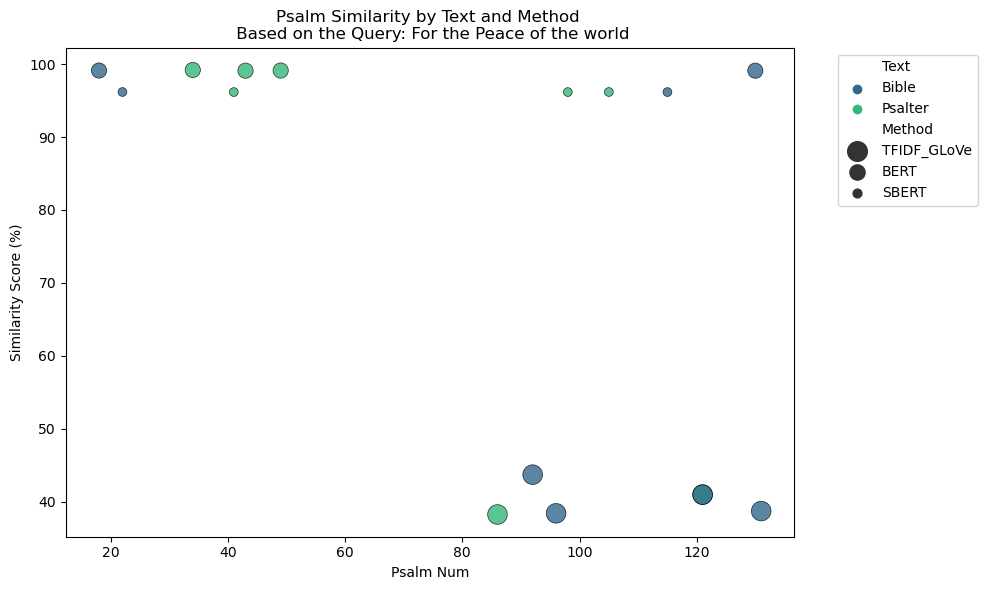

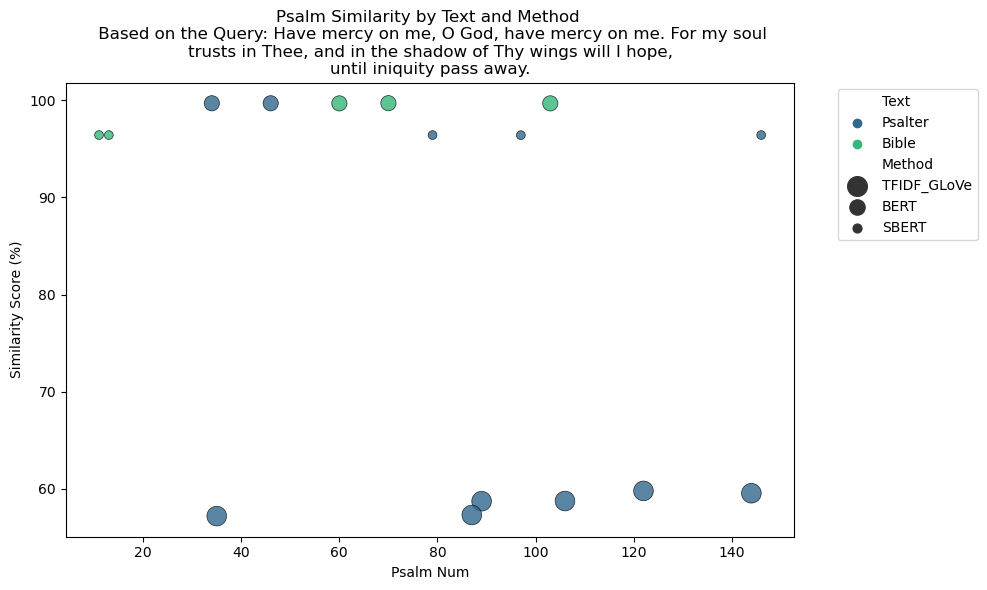

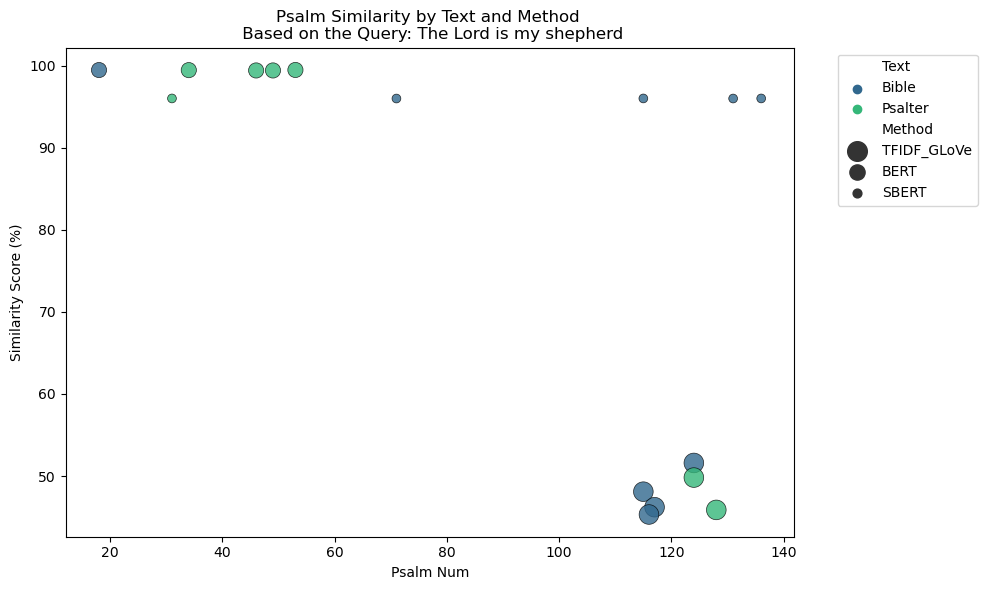

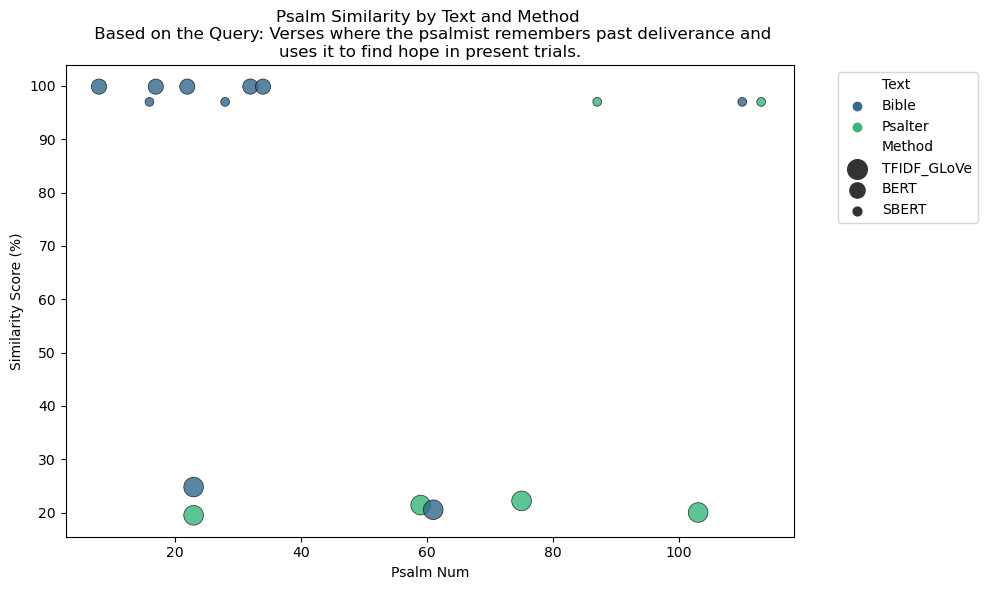

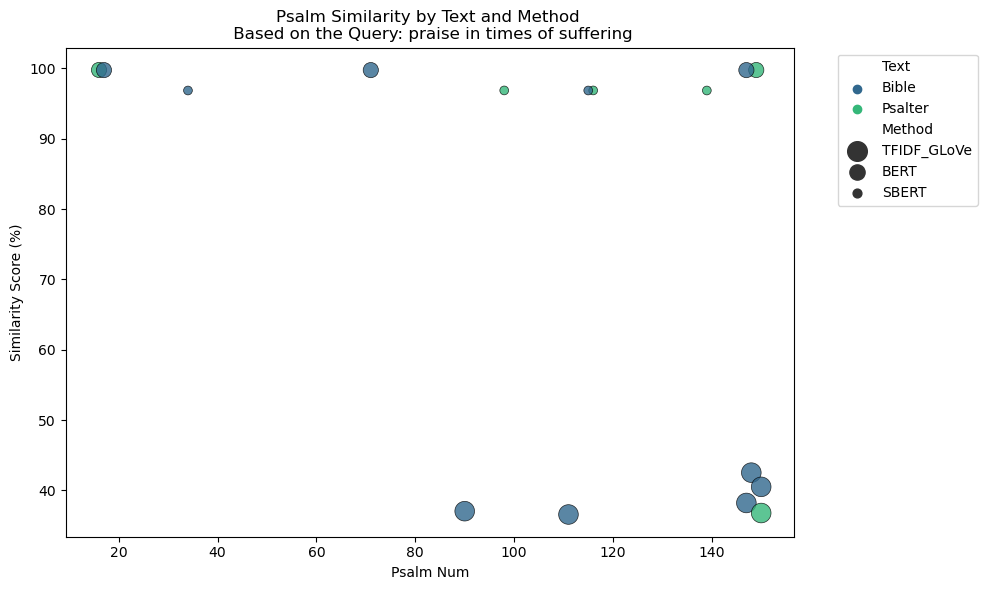

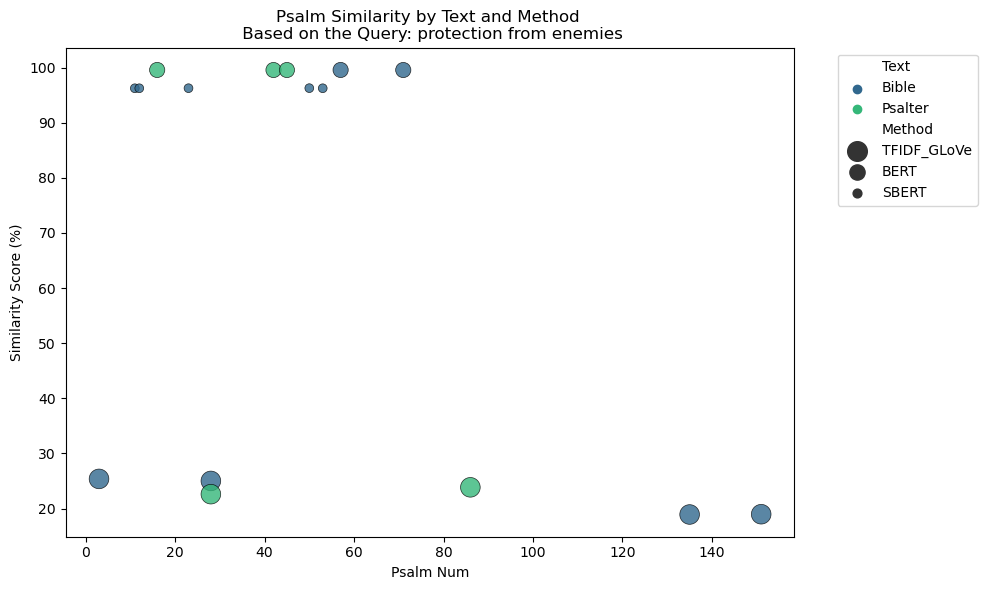

In [175]:
for q, group in grouped_queries:
    graph_results(group)

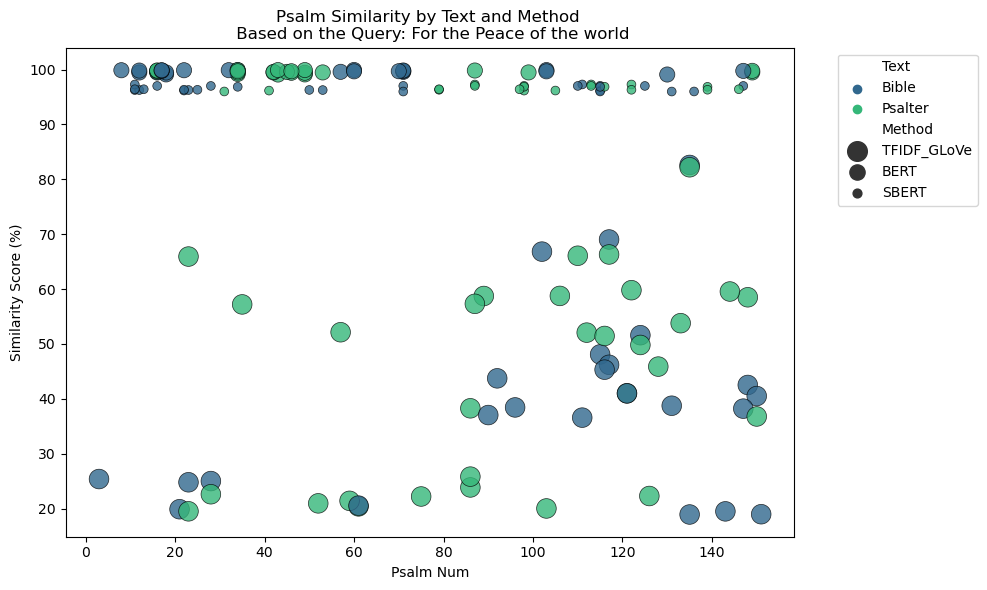

In [178]:
graph_results(full_results)

In [177]:
full_results.to_csv("full_results.csv", index=False)